> &nbsp;  
> _Note: In this document, MarkDown sections marked with a vertical bar (like the current section) correspond to user inputs. All other sections are the transcribed requirements of the assignment_  
> &nbsp;  

In [1]:
import tensorflow as tf
from keras import Sequential, Model
from keras.layers import Dense,Conv2D,MaxPooling2D,BatchNormalization,Dropout,GlobalAveragePooling2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn as sk
import numpy as np

In [2]:
# Display the version of tensorflow, sklearn, and the GPU
print(f'TensorFlow: {tf.__version__}')
print(f'Scikit-learn: {sk.__version__}')
gpus = tf.config.list_physical_devices('GPU')
print(f'GPUs: {gpus if gpus else "None"}')

TensorFlow: 2.16.1
Scikit-learn: 1.2.2
GPUs: None


## Perform the following steps:
1.	Build a CNN network to classify the boat.
    1.	Split the dataset into train and test in the ratio 80:20, with shuffle and random state=43.

> &nbsp;  
> _Note that the data split is done with the default scikit-learn train_test_split function with stratification, in order to keep consistent ratios across classes._  
> &nbsp;

In [3]:
import os, shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# find all the jpg files one layer deeper in the 'data/source/' folder
files = pd.Series()
folders = pd.Series()
idx = 0
for root, dirs, fs in os.walk('./data/source'):
    for f in fs:
        if (f.endswith('.jpg')):
            files.at[idx] = os.path.join(root, f).replace('\\', '/')
            folders.at[idx] = os.path.basename(root)
            idx += 1

# Copy the files to the correct folders
def copy_files(files, dest):
    destpath = f"./data/{dest}"
    if os.path.exists(destpath):
        shutil.rmtree(destpath)
    os.makedirs(destpath)
    for f in files:
        f_target = f.replace('source', dest)
        if (not os.path.exists(os.path.dirname(f_target))):
            os.makedirs(os.path.dirname(f_target))
        shutil.copy(f, f_target)

# Split the files and folders into train and test sets
def split_files(files, folders, test_size, train_folder, test_folder, random_state):
    files_train, files_test, folders_train, folders_test = train_test_split(
        files, folders, test_size=test_size, shuffle = True, random_state=random_state, stratify=folders)
    # Create and display a dataframe of file counts by folder for the train and test sets (columns)
    df = pd.DataFrame()
    df['train'] = folders_train.value_counts()
    df['test'] = folders_test.value_counts()
    display(df)
    copy_files(files_train, train_folder)
    copy_files(files_test, test_folder)

split_files(files, folders, 0.2, 'train', 'test', 43)

train  test
sailboat           311    78
kayak              162    41
gondola            154    39
cruise_ship        153    38
ferry_boat          50    13
buoy                42    11
paper_boat          25     6
freight_boat        19     4
inflatable_boat     13     3

1. ...

   2. Use Keras ImageDataGenerator to initialize the train generator with validation_split=0.2 and test generator. Generators are required to avoid out of memory issues while training.
   2. Both generators will be initialized with data normalization. _(Hint: rescale=1./255)._
   2. Load train, validation and test dataset in batches of 32 using the generators initialized in the above step.

> &nbsp;  
> _Note 1: While a batch size of 32 makes sense for stabilizing backprop feedback into the layers, there's no reason to do that for the test dataset.  To retain the ability to easily look at individual test samples, the batch size for the test set is set to 1._  
> _Note 2: This is a pretty small training data set for computer vision, so image augmentation is being added to the training dataset.  This augmentation is intended to be consistent with seaport realities (e.g., no vertical flip, and minimal rotation range)._  
> _Note 3: The requirement is to use the (deprecated) `ImageDataGenerator` class with generators set with the `validation_split` parameter. This does_ **not** _maintain ratios across classes, which could negatively impact the quality of the training. Conversely, the data set is quite imbalanced and one should probably focus on data augmentation for the smaller classes to achieve best results.  However, this falls outside the requirements for this assignment._
> &nbsp;


In [4]:
from random import shuffle


def create_generators(train_dir: str, test_dir: str, val_split: float, image_size: int):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=[0.8,1.2],
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=val_split)
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=43)
    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        seed=43)
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=1,
        class_mode='categorical',
        shuffle=False,
        seed=43)
    return (train_generator, validation_generator, test_generator)

train_generator, validation_generator, test_generator = create_generators('./data/train', './data/test', 0.2, 150)

Found 747 images belonging to 9 classes.
Found 182 images belonging to 9 classes.
Found 233 images belonging to 9 classes.


1. ...

    5.	Build a CNN network using Keras with the following layers
        - Cov2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D
        - Cov2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D
        - GLobalAveragePooling2D layer
        - Dense layer with 128 neurons and activation relu
        - Dense layer with 128 neurons and activation relu
        - Dense layer with 9 neurons and activation softmax.

In [5]:
cnn = Sequential()

cnn.add(Input(shape=(150, 150, 3)))
cnn.add(Conv2D(32, (3, 3), activation='relu', padding='valid'))
cnn.add(MaxPooling2D((2, 2), strides=2, padding='valid'))
cnn.add(Conv2D(32, (3, 3), activation='relu', padding='valid'))
cnn.add(MaxPooling2D((2, 2), strides=2, padding='valid'))
cnn.add(GlobalAveragePooling2D())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(9, activation='softmax'))

1. ...

    6. Compile the model with Adam optimizer, categorical_crossentropy loss, and with metrics accuracy, precision, and recall.

In [6]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,041 (125.16 KB)

 Trainable params: 32,041 (125.16 KB)

 Non-trainable params: 0 (0.00 B)

1. ...  

    7. Train the model for 20 epochs and plot training loss and accuracy against epochs.
    7. Evaluate the model on test images and print the test loss and accuracy.

> &nbsp;  
> _Note: the test loss and accuracy are included in the plots below_  
> &nbsp;

In [7]:
import warnings
warnings.filterwarnings("ignore")

history_cnn = cnn.fit(train_generator, validation_data=validation_generator, epochs=20)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 874ms/step - accuracy: 0.2481 - loss: 2.0699 - precision: 0.3198 - recall: 0.0043 - val_accuracy: 0.3407 - val_loss: 1.7349 - val_precision: 1.0000 - val_recall: 0.0110
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 469ms/step - accuracy: 0.3212 - loss: 1.8067 - precision: 0.2400 - recall: 3.4767e-04 - val_accuracy: 0.3407 - val_loss: 1.7409 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 466ms/step - accuracy: 0.3214 - loss: 1.8135 - precision: 0.2400 - recall: 0.0014 - val_accuracy: 0.3407 - val_loss: 1.7326 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 466ms/step - accuracy: 0.3437 - loss: 1.7712 - precision: 0.6820 - recall: 0.0197 - val_accuracy: 0.3407 - val_loss: 1.7247 - val_precision: 1.0000 - val_recall: 0.0055
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 488ms/step - accuracy: 0.3285 - loss: 1.8326 - precision: 0.4484 - recall: 0.0081 - val_accura

233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step


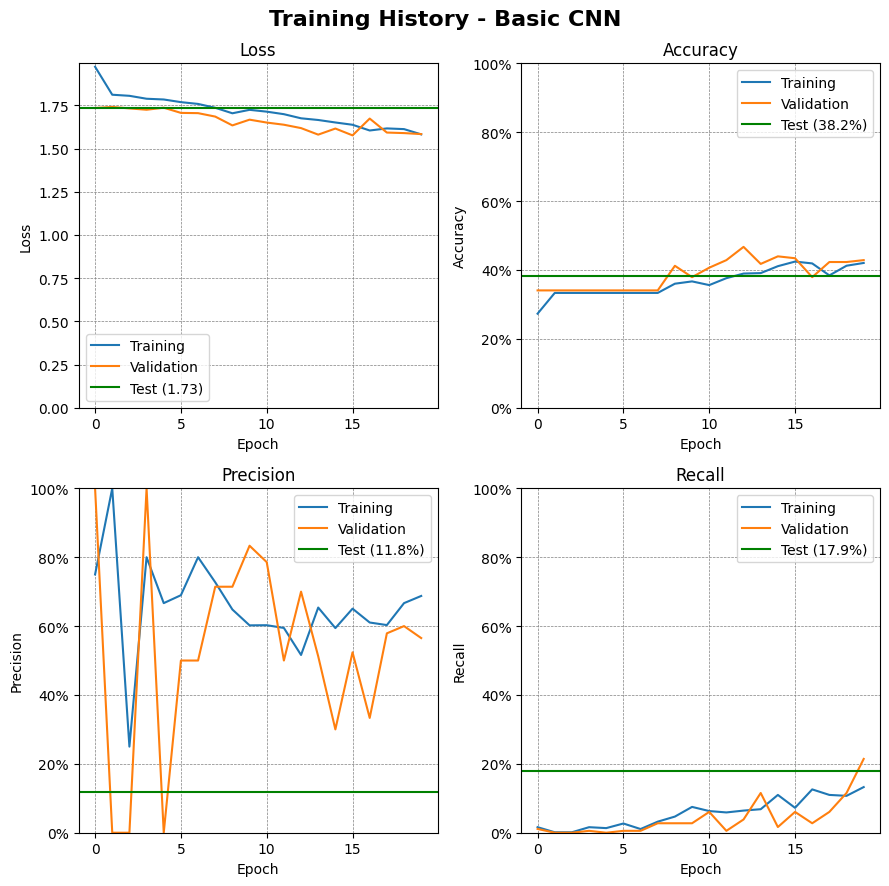

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import accuracy_score, precision_score, recall_score
from typing import Dict

def quality_scores(model: Model, generator: ImageDataGenerator) -> Dict[str, float]:
    pred = model.predict(generator)
    pred_labels = np.argmax(pred, axis=1) # Turn "one-hot encoding"-like probabilities into integer encoding for easier comparison with true labels
    retval = {}
    retval['accuracy'] = accuracy_score(generator.labels, pred_labels)
    retval['precision'] = precision_score(generator.labels, pred_labels, average='macro')
    retval['recall'] = recall_score(generator.labels, pred_labels, average='macro')
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    retval['loss'] = loss_func(generator.labels, pred)
    return retval

def training_subplot(hist, metric: str, plotnum: int, lim = None, test_val = None):
    sp = plt.subplot(2, 2, plotnum)
    plt.plot(hist.history[metric], label='Training')
    plt.plot(hist.history['val_' + metric], label='Validation')
    if (test_val is not None):
        test_lbl = 'Test ' + (f'({test_val:.1%})' if (lim == 1) else f'({test_val:.2f})')
        plt.axhline(y=test_val, label=test_lbl, color='green', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.ylim(0, lim)
    plt.xlim(0, len(hist.history[metric]) - 1)
    if (lim == 1):
        sp.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5, color='grey')
    plt.title(metric.capitalize())

def training_plot(hist, model: Model, generator: ImageDataGenerator, title='Training History'):
    quality = quality_scores(model, generator)
    # Plot the training history (loss and accuracy) in two subplots
    plt.figure(figsize=(9, 9))
    plt.suptitle(title, fontsize=16, fontweight='bold')
    training_subplot(hist, 'loss', 1, test_val=quality['loss'])
    training_subplot(hist, 'accuracy', 2, 1, test_val=quality['accuracy'])
    training_subplot(hist, 'precision', 3, 1, test_val=quality['precision'])
    training_subplot(hist, 'recall', 4, 1, test_val=quality['recall'])
    plt.tight_layout()
    plt.show()

training_plot(history_cnn, cnn, test_generator, "Training History - Basic CNN")

233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


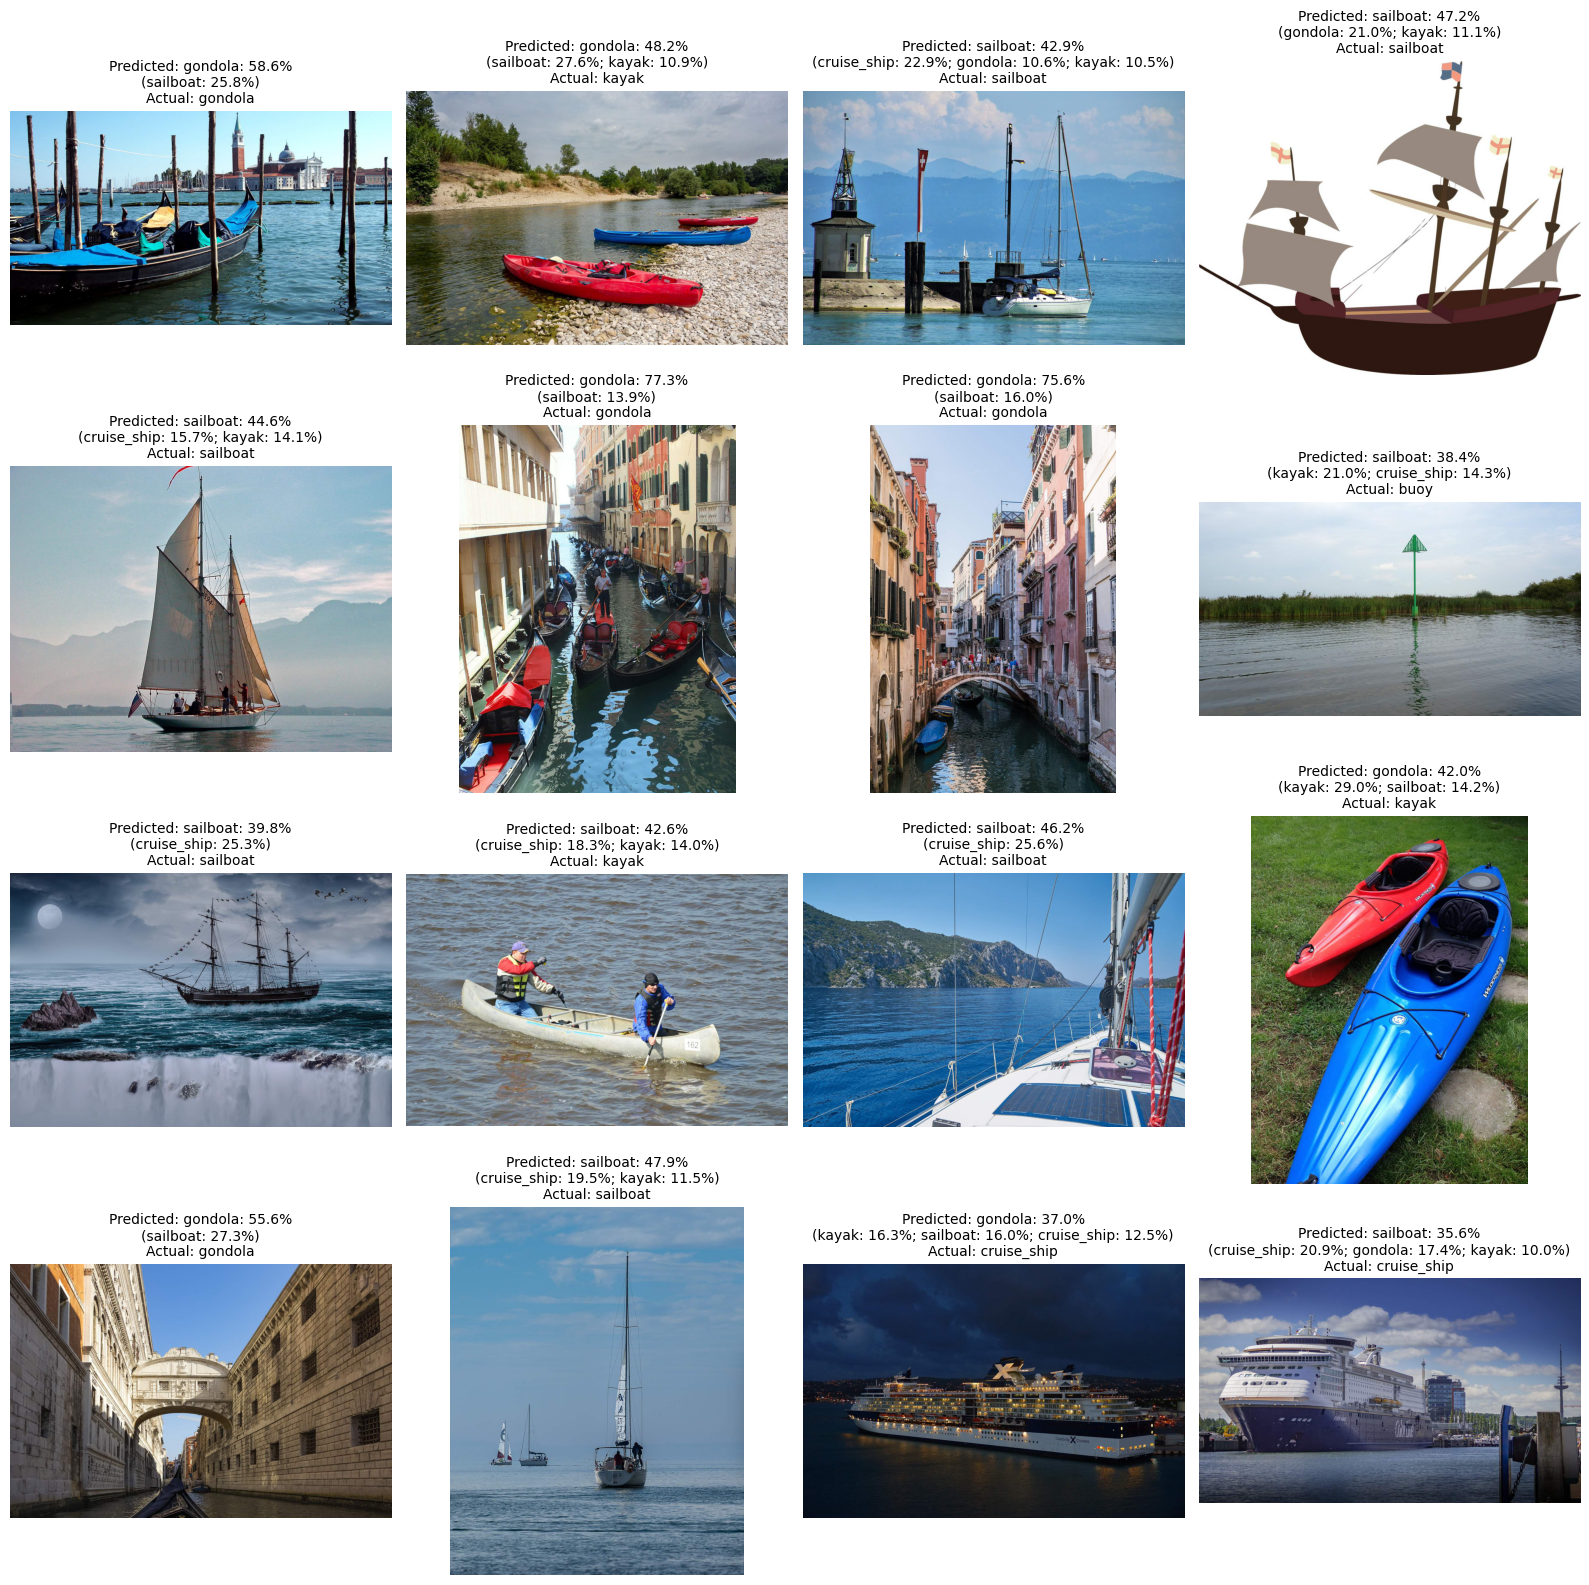

In [9]:
def predict_and_display(model: Model, generator: ImageDataGenerator, path: str):
    pred = model.predict(generator)
    class_names = [k for k in generator.class_indices.keys()]
    if not path.endswith('/'):
        path += '/'

    plt.figure(figsize=(16, 16))
    picked_image_indexes = []
    for i in range(16):
        # pick a random image index that hasn't been picked yet
        idx = None
        while (idx is None or idx in picked_image_indexes):
            idx = np.random.randint(0, len(generator.filenames))
        picked_image_indexes.append(idx)
        # Show top probability(ies) greater than 10%
        top_preds = [(str(k), f"{round(float(v),3):.1%}") for k, v in zip(generator.class_indices.keys(), pred[idx]) if v >= 0.1]
        top_preds.sort(key=lambda x: x[1], reverse=True)
        top_pred_str = f"{top_preds[0][0]}: {top_preds[0][1]}"
        if (len(top_preds) > 1):
            top_pred_str += "\n(" + "; ".join([f"{k}: {v}" for k, v in top_preds[1:]]) + ")" 
        # Show image
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(plt.imread(f"{path}{generator.filenames[idx]}"))
        plt.title(f"Predicted: {top_pred_str}\nActual: {class_names[generator.labels[idx]]}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

predict_and_display(cnn, test_generator, "./data/test")

1. ...  

    9. Plot heatmap of the confusion matrix and print classification report  

233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


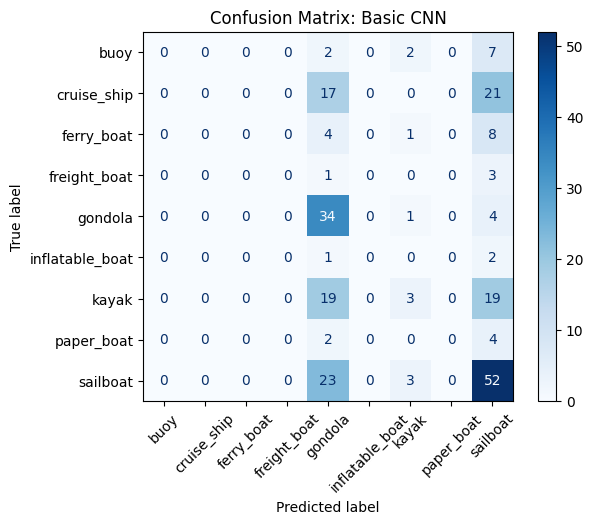

                 precision    recall  f1-score   support

           buoy       0.00      0.00      0.00        11
    cruise_ship       0.00      0.00      0.00        38
     ferry_boat       0.00      0.00      0.00        13
   freight_boat       0.00      0.00      0.00         4
        gondola       0.33      0.87      0.48        39
inflatable_boat       0.00      0.00      0.00         3
          kayak       0.30      0.07      0.12        41
     paper_boat       0.00      0.00      0.00         6
       sailboat       0.43      0.67      0.53        78

       accuracy                           0.38       233
      macro avg       0.12      0.18      0.12       233
   weighted avg       0.25      0.38      0.28       233



In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def confusion_matrix_and_classification_report(model: Model, generator: tf.keras.preprocessing.image.DirectoryIterator, title: str):
    # Generate predictions
    test_pred = model.predict(generator)
    predicted_labels = test_pred.argmax(axis=1)
    class_names = generator.class_indices.keys()
    # Compute the confusion matrix
    cm = confusion_matrix(generator.labels, predicted_labels)
    # Plot the confusion matrix
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_names)
    cm_display.plot(cmap='Blues', values_format='d', xticks_rotation=45)
    plt.title('Confusion Matrix: ' + title)
    plt.show()
    # Display the classification report
    print(classification_report(generator.labels, predicted_labels, target_names=class_names))

confusion_matrix_and_classification_report(cnn, test_generator, 'Basic CNN')


2.	Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API.  
    1. Split the dataset into train and test datasets in the ration 70:30, with shuffle and random state=1. 

In [11]:
split_files(files, folders, 0.3, 'lm_train', 'lm_test', 1)

train  test
sailboat           272   117
kayak              142    61
gondola            135    58
cruise_ship        134    57
ferry_boat          44    19
buoy                37    16
paper_boat          22     9
freight_boat        16     7
inflatable_boat     11     5

2. ...  

    2. Use Keras ImageDataGenerator to initialize the train generator with validation_split=0.2 and test generator. Generators are required to avoid out-of-memory issues while training.  
    2. Both generators will be initialized with data normalization. _(Hint: rescale=1./255)._  
    2. Load train, validation and test datasets in batches of 32 using the generators initialized in the above step.

> &nbsp;  
> Note: MobileNetV2 uses an image size of 224, so this value is used here instead of the 150 setting used earlier.  
> &nbsp;  

In [12]:
train_lm_generator, validation_lm_generator, test_lm_generator = create_generators('./data/lm_train', './data/lm_test', 0.2, 224)

Found 654 images belonging to 9 classes.
Found 159 images belonging to 9 classes.
Found 349 images belonging to 9 classes.


2. ...  

    5. Build a CNN network using Keras with the following layers.  
        * Load MobileNetV2 - Light Model as the first layer _(Hint: Keras API Doc)_
        * GLobalAveragePooling2D layer
        * Dropout(0.2)
        * Dense layer with 256 neurons and activation relu
        * BatchNormalization layer
        * Dropout(0.1)
        * Dense layer with 128 neurons and activation relu
        * BatchNormalization layer
        * Dropout(0.1)
        * Dense layer with 9 neurons and activation softmax


In [13]:
from keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

lm_cnn = Sequential()
lm_cnn.add(base_model)
lm_cnn.add(GlobalAveragePooling2D())
lm_cnn.add(Dropout(0.2))
lm_cnn.add(Dense(256, activation='relu'))
lm_cnn.add(BatchNormalization())
lm_cnn.add(Dropout(0.1))
lm_cnn.add(Dense(128, activation='relu'))
lm_cnn.add(BatchNormalization())
lm_cnn.add(Dropout(0.1))
lm_cnn.add(Dense(9, activation='softmax'))

2. ...  

    6.	Compile the model with Adam optimizer, categorical_crossentropy loss, and metrics accuracy, Precision, and Recall.

In [14]:
lm_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

lm_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

2. ...  

    7. Train the model for 50 epochs and Early stopping while monitoring validation loss.  

> &nbsp;  
> _Note: I'm assuming that this means_ **at most** _50 epochs of training with early stopping to occur before these 50 epochs (if at all)_  
> &nbsp;

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss', verbose=1, start_from_epoch=25)

In [16]:
import warnings
warnings.filterwarnings("ignore")

history_lm_cnn = lm_cnn.fit(train_lm_generator, validation_data=validation_lm_generator, epochs=50, callbacks=[early_stopping])

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3969 - loss: 1.8439 - precision: 0.5811 - recall: 0.2848 - val_accuracy: 0.7421 - val_loss: 0.8475 - val_precision: 0.8718 - val_recall: 0.6415
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 799ms/step - accuracy: 0.8118 - loss: 0.6176 - precision: 0.8699 - recall: 0.7497 - val_accuracy: 0.7799 - val_loss: 0.7344 - val_precision: 0.9016 - val_recall: 0.6918
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 785ms/step - accuracy: 0.8461 - loss: 0.4853 - precision: 0.9234 - recall: 0.7860 - val_accuracy: 0.8050 - val_loss: 0.7013 - val_precision: 0.8864 - val_recall: 0.7358
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 798ms/step - accuracy: 0.8867 - loss: 0.3646 - precision: 0.9248 - recall: 0.8388 - val_accuracy: 0.8050 - val_loss: 0.6519 - val_precision: 0.8705 - val_recall: 0.7610
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 821ms/step - accuracy: 0.9099 - loss: 0.2981 - precision: 0.9366 - recall: 0.8797 - val_accuracy: 0.8302 - val_loss: 

2. ...  

    8. Evaluate the model on test images and print the test loss and accuracy.  

349/349 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step


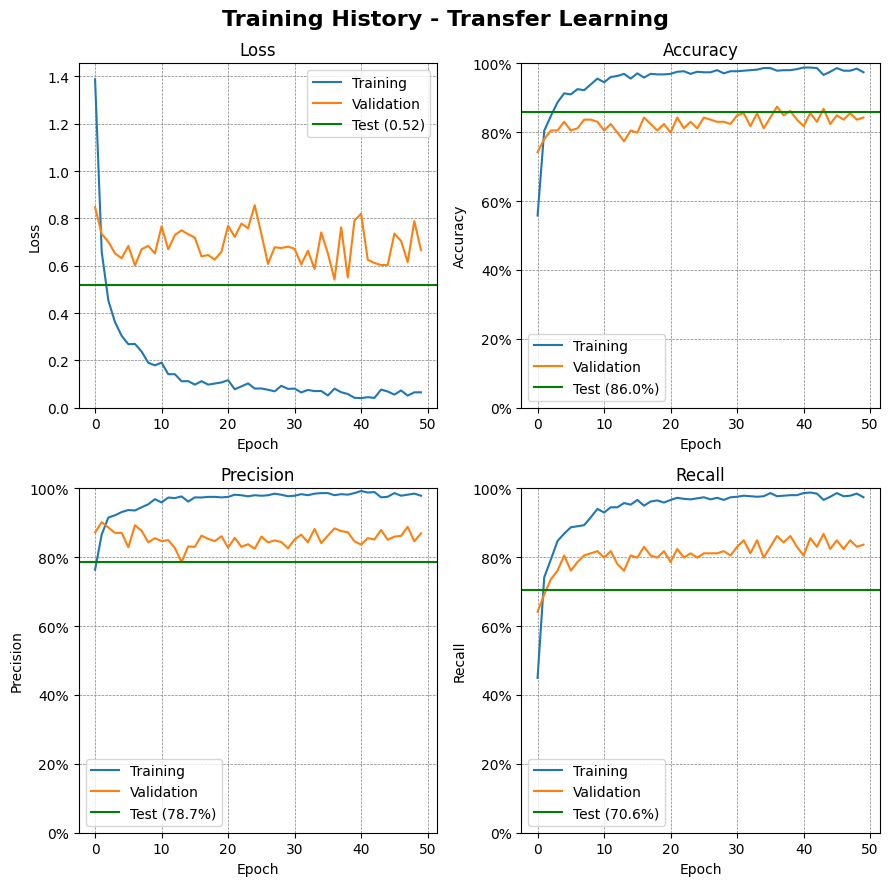

In [17]:
training_plot(history_lm_cnn, lm_cnn, test_lm_generator, "Training History - Transfer Learning")

349/349 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step


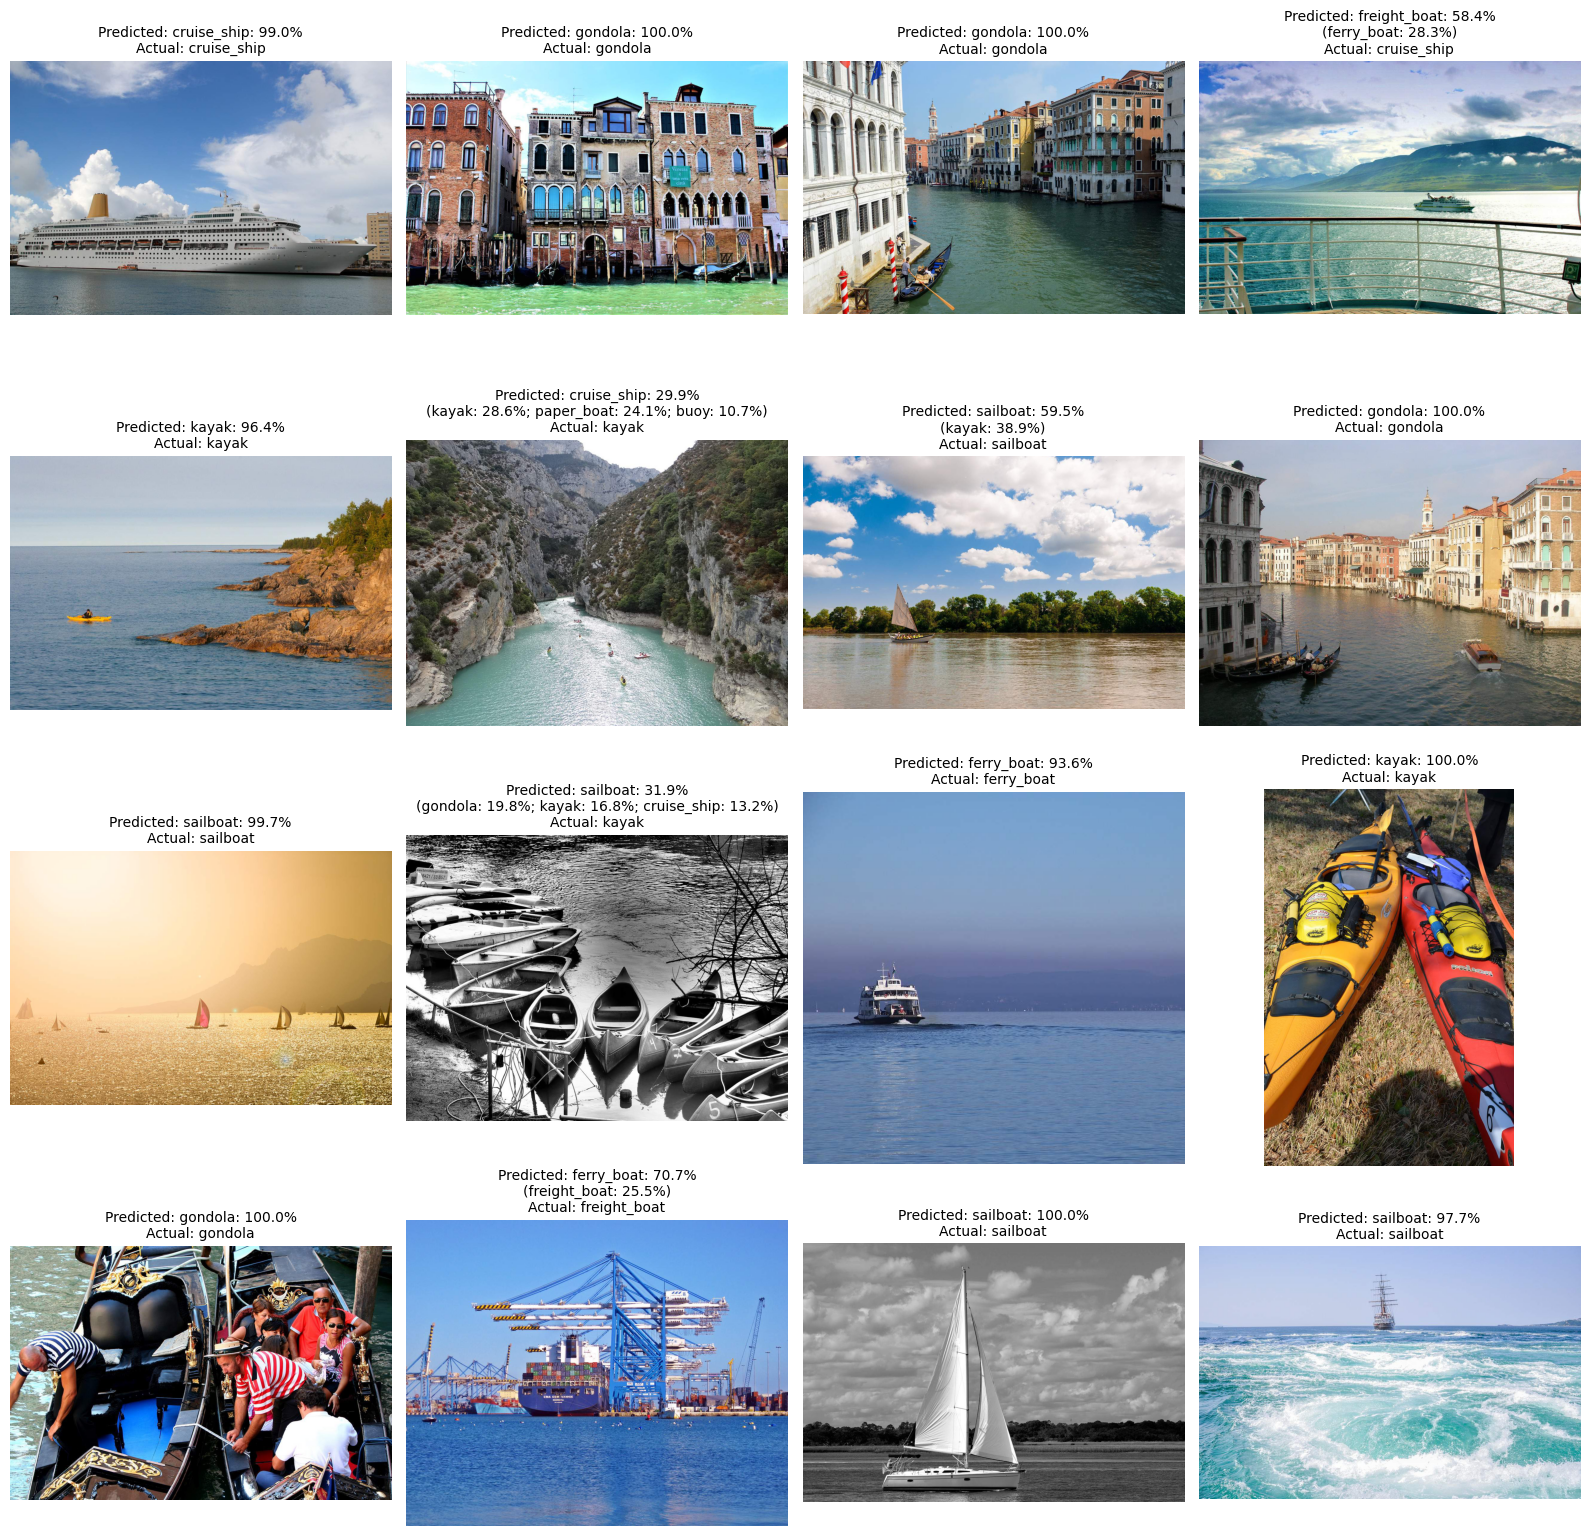

In [18]:
predict_and_display(lm_cnn, test_lm_generator, "./data/lm_test")


349/349 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


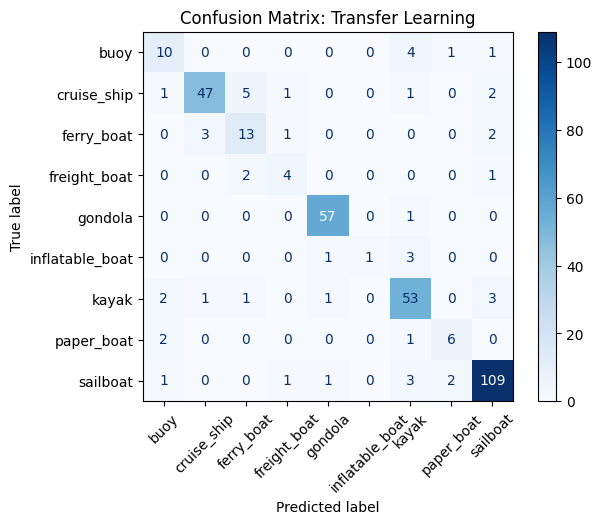

                 precision    recall  f1-score   support

           buoy       0.62      0.62      0.62        16
    cruise_ship       0.92      0.82      0.87        57
     ferry_boat       0.62      0.68      0.65        19
   freight_boat       0.57      0.57      0.57         7
        gondola       0.95      0.98      0.97        58
inflatable_boat       1.00      0.20      0.33         5
          kayak       0.80      0.87      0.83        61
     paper_boat       0.67      0.67      0.67         9
       sailboat       0.92      0.93      0.93       117

       accuracy                           0.86       349
      macro avg       0.79      0.71      0.72       349
   weighted avg       0.86      0.86      0.86       349



In [19]:
confusion_matrix_and_classification_report(lm_cnn, test_lm_generator, 'Transfer Learning')


2. ...  

    9. Plot Train loss Vs Validation loss and Train accuracy Vs Validation accuracy.


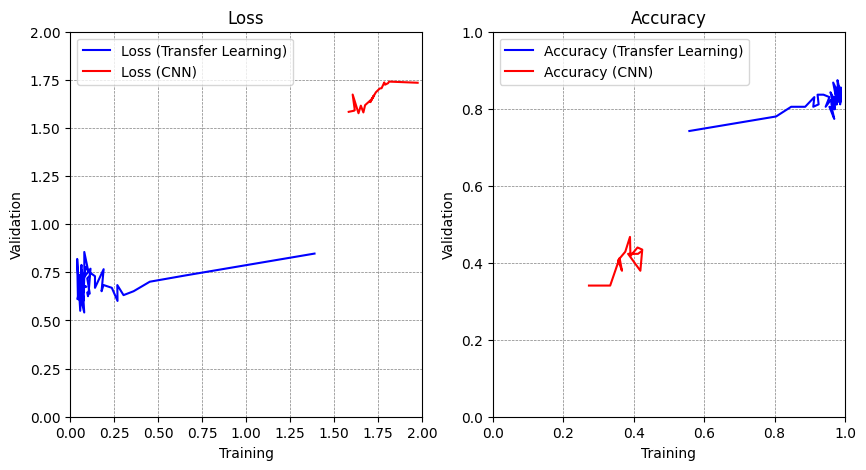

In [20]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_lm_cnn.history['loss'], history_lm_cnn.history['val_loss'], label='Loss (Transfer Learning)', color='blue', marker=None)
plt.plot(history_cnn.history['loss'], history_cnn.history['val_loss'], label='Loss (CNN)', color='red', marker=None)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.title('Loss')
plt.xlabel('Training')
plt.ylabel('Validation')
plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5, color='grey')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lm_cnn.history['accuracy'], history_lm_cnn.history['val_accuracy'], label='Accuracy (Transfer Learning)', color='blue', marker=None)
plt.plot(history_cnn.history['accuracy'], history_cnn.history['val_accuracy'], label='Accuracy (CNN)', color='red', marker=None)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Accuracy')
plt.xlabel('Training')
plt.ylabel('Validation')
plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5, color='grey')
plt.legend()

plt.show()


3.	Compare the results of both models built in steps 1 and 2 and state your observations.

> ### Basic CNN  
> The basic convolutional neural network built and trained in step one achieves behaves horribly, as expected, barely achieving an accuracy of 38.2%.  This is in large part due to the fact that training was limited to 20 epochs.  Even for a very small CNN (64 3x3 filter split over 2 Conv2D layers, followed by 2 128-node classification layers), training the feature extraction (Conv2Ds) _and_ classification (the dense layers) requires definitely more training than that.  
> Indeed, the confusion matrix for the basic CNN clearly shows that the only thing that was "learned" is that most images are sailboats (primarily), gondolas, or kayaks.  Most of the predictions fall into one of these 3 classes. The confusion matrix looks like 2 columns (sailboats and gondolas), instead of looking like a diagonal.
> There are 2 primary things that could be done to alleviate this issue, even with such a simple network:  
> * More training epochs should be run, maybe with an `EarlyStopping` callback so that training stops before overfitting occurs.
> * Lower-count classes should be augmented so that the network learns to recognize them.  This could be done by either using some keras-based augmentation algorithms or, better, searching the internet for matching images and adding them to the dataset

> ### Transfer Learning
> Using Mobile Net (V2) frozen and simply training the classifier subnetwork significantly improves to about 85%, and the confusion matrix looks like a diagonal.  
> This clearly shows the advantage of using pre-trained networks for image classification: the feature extraction is already present, and it's mostly just the classifier that needs to be re-trained (i.e., the dense layers).  
> Having said that, however, 85% accuracy is still less than desirable for commercial applications, especially if there are large costs (monetary or otherwise) associated with mis-classifications.  To improve accuracy and recall, hence the following further work could be done:  
> * As noted for the Basic CNN above, the class imbalance in the source data _should_ very much be alleviated (with some computational or actual data augmentation for the smaller classes)  
> * Further training should be done of the overall network, maybe by increasing early stopping `patience` and decreasing the learning rate when a plateau occurs.
> * Once the classifier is trained, un-freeze the feature extractor (or parts thereof) to allow for fine-tuning of Mobile Net V2 for boat identification.